## Importing headers

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Data Loading and Exploration

In [3]:
ticker = "AAPL"
df = yf.download(ticker, start="2020-01-01")
df

C:\Users\rk\AppData\Local\Temp\ipykernel_13964\101187372.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2020-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620827,72.681274,71.373203,71.627077,135480400
2020-01-03,71.914825,72.676454,71.689965,71.847125,146322800
2020-01-06,72.487839,72.526526,70.783241,71.034702,118387200
2020-01-07,72.146957,72.753839,71.926930,72.497545,108872000
2020-01-08,73.307503,73.609737,71.849525,71.849525,132079200
...,...,...,...,...,...
2025-07-28,214.050003,214.850006,213.059998,214.029999,37858000
2025-07-29,211.270004,214.809998,210.820007,214.179993,51411700


<Axes: xlabel='Date'>

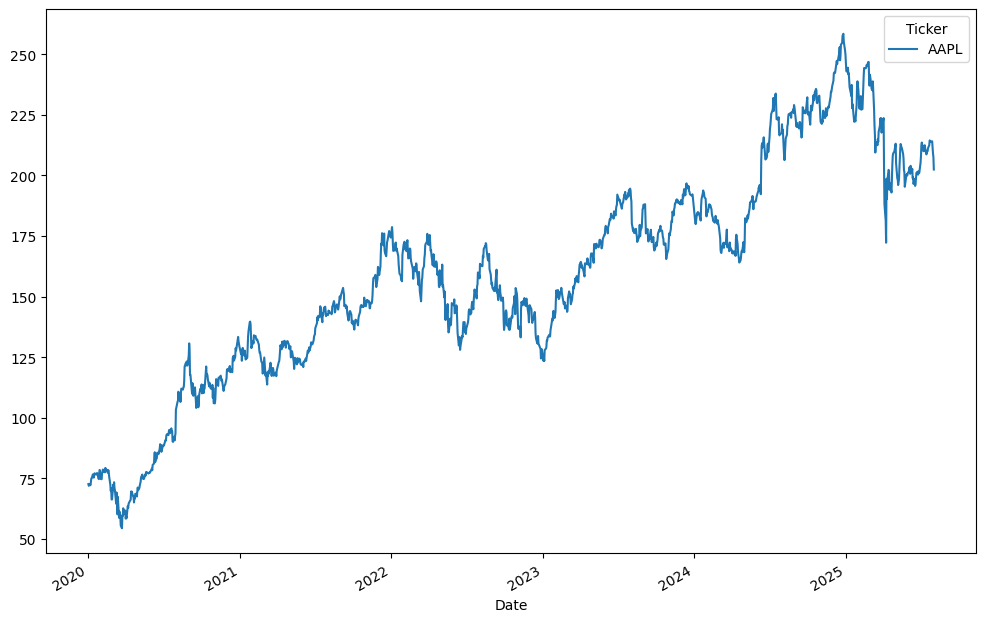

In [4]:
df.Close.plot(figsize=(12,8))

In [5]:
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df[['Close']])

In [6]:
df.Close

Ticker,AAPL
Date,
2020-01-02,-1.929942
2020-01-03,-1.945800
2020-01-06,-1.932929
2020-01-07,-1.940586
2020-01-08,-1.914517
...,...
2025-07-28,1.246965
2025-07-29,1.184518
2025-07-30,1.134651


In [ ]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])    # Each sequence overlaps with the previous one by 29 elements.

data = np.array(data)

There is overlap. That is if input is 1,2 then test is 3, the next set will be input --> 2,3 and pred --> 4  
  

![](./image.png)  
  
  The arrow shows pred value

In [9]:
data

array([[[-1.92994152],
        [-1.94580034],
        [-1.93292881],
        ...,
        [-1.82121595],
        [-1.77989513],
        [-1.7925802 ]],

       [[-1.94580034],
        [-1.93292881],
        [-1.94058599],
        ...,
        [-1.77989513],
        [-1.7925802 ],
        [-1.79214404]],

       [[-1.93292881],
        [-1.94058599],
        [-1.9145168 ],
        ...,
        [-1.7925802 ],
        [-1.79214404],
        [-1.82453674]],

       ...,

       [[ 0.89587022],
        [ 0.83342344],
        [ 0.8545386 ],
        ...,
        [ 1.2431465 ],
        [ 1.24696515],
        [ 1.18451837]],

       [[ 0.83342344],
        [ 0.8545386 ],
        [ 0.95382449],
        ...,
        [ 1.24696515],
        [ 1.18451837],
        [ 1.13465074]],

       [[ 0.8545386 ],
        [ 0.95382449],
        [ 0.96505593],
        ...,
        [ 1.18451837],
        [ 1.13465074],
        [ 1.10140578]]])

In [17]:
train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]) # first 29 elements in all sequences
y_train = torch.from_numpy(data[:train_size, -1, :])  # last element ie 30th element

X_test = torch.from_numpy(data[train_size:, :-1, :])  # only diff is no :train_size but starts from train_size:
y_test = torch.from_numpy(data[train_size:, -1, :])

#### Why We Don't Shuffle Time Series Data

Unlike regular machine learning tasks (e.g., classification with `train_test_split(shuffle=True)`), time series data has a **temporal order**.

Shuffling the data would break the sequence of events and **leak future information into the past**, making the model unrealistic and invalid for real-world prediction.

So we keep the **older data for training** and the **newer data for testing**, preserving the timeline and making the prediction task reflect real scenarios.


In [21]:
print(f"X_train shape : {X_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"X_test shape  : {X_test.shape}")
print(f"y_test shape  : {y_test.shape}")

X_train shape : torch.Size([1098, 29, 1])
y_train shape : torch.Size([1098, 1])
X_test shape  : torch.Size([275, 29, 1])
y_test shape  : torch.Size([275, 1])
